In [17]:
%load_ext autoreload
%autoreload 2
from src.chem_draw import draw_rxn_svg, draw_pwy_svg
from src.utils import sort_x_by_y, ensure_dirs
from svgutils import compose as sc
import pickle
import numpy as np
import matplotlib.pyplot as plt
import os

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
# Params
expansion_dir = '../data/processed_expansions/'
fn = "succinate_to_mvacid_gen_4_tan_sample_n_samples_1000.pk" # Expansion file name
rxns_path = expansion_dir + 'predicted_reactions_' + fn
paths_path = expansion_dir + 'paths_' + fn

In [19]:
# Load reactions and paths
with open(rxns_path, 'rb') as f:
    pred_rxns = pickle.load(f)

with open(paths_path, 'rb') as f:
    paths = pickle.load(f)

In [20]:
# Count how many pathways have full info

n_paths_w_full_info = 0
for p in paths:
    path_full_info = []
    for rh in p.rhashes:
        full_info = False
        for elt in pred_rxns[rh].known_rxns:
            if elt[0] is not None:
                full_info = True
                break

        path_full_info.append(full_info)
    
    if all(path_full_info):
        n_paths_w_full_info += 1

print(n_paths_w_full_info / len(paths), len(paths))


0.5365853658536586 41


In [21]:
# Sort known reactions by average (could alter the sort by value)
for k in pred_rxns.keys():
    pred_rxns[k].sort_known_rxns()

In [22]:
# Set prc mcs attribute for each path by averaging over 
# known reactions
for p in paths:
    p.compute_mean_prc_mcs(pred_rxns)

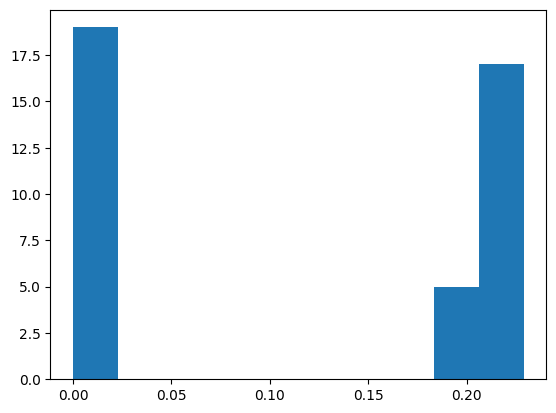

In [23]:
# Sort paths by min reaction prc mcs
min_prc_mcs = []
for p in paths:
    min_prc_mcs.append(p.min_mcs())

min_sorted_idxs = np.arange(len(paths))

min_sorted_idxs, min_prc_mcs = sort_x_by_y(min_sorted_idxs, min_prc_mcs, reverse=True)

plt.hist(min_prc_mcs)
plt.show()

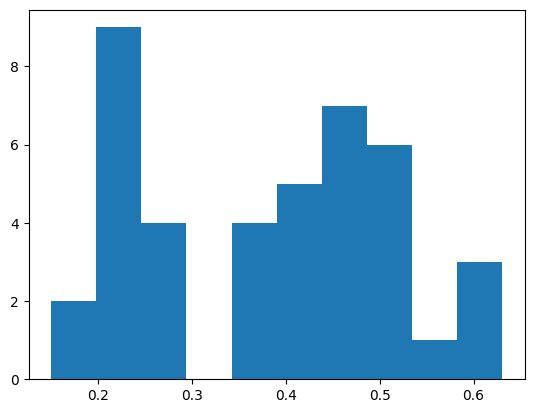

In [24]:
# Sort paths by min reaction prc mcs
mean_prc_mcs = []
for p in paths:
    mean_prc_mcs.append(p.mean_mcs())

mean_sorted_idxs = np.arange(len(paths))

mean_sorted_idxs, mean_prc_mcs = sort_x_by_y(mean_sorted_idxs, mean_prc_mcs, reverse=True)

plt.hist(mean_prc_mcs)
plt.show()

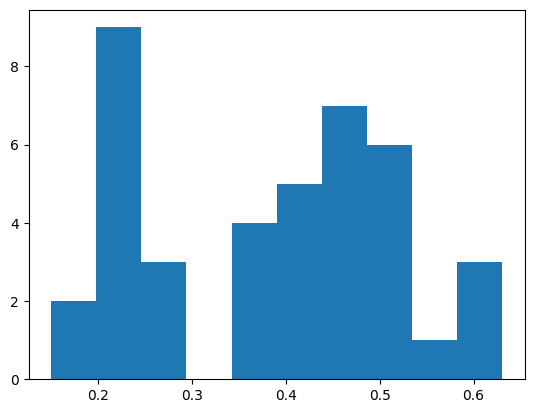

In [25]:
# First sort by min prc_mcs and threshold and then sort by mean prc_mcs

min_thresh = 0.05

# Get min prc_mcs
min_prc_mcs = []
for p in paths:
    min_prc_mcs.append(p.min_mcs())

# Sort indices by min prc_mcs
min_sorted_idxs = np.arange(len(paths))
min_sorted_idxs, min_prc_mcs = sort_x_by_y(min_sorted_idxs, min_prc_mcs, reverse=True)

# Remove zero mins
min_sorted_idxs, min_prc_mcs = np.array(min_sorted_idxs), np.array(min_prc_mcs)
min_sorted_idxs = min_sorted_idxs[min_sorted_idxs > min_thresh]

# Get mean prc_mcs of non-zero min paths
mean_prc_mcs = []
for idx in min_sorted_idxs:
    mean_prc_mcs.append(paths[idx].mean_mcs())

min_mean_sorted_idxs, mean_prc_mcs = sort_x_by_y(min_sorted_idxs, mean_prc_mcs, reverse=True)

plt.hist(mean_prc_mcs)
plt.show()

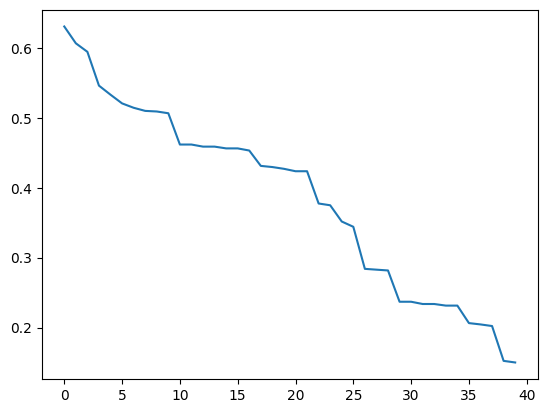

In [26]:
plt.plot(mean_prc_mcs)
plt.show()

In [27]:
n_pwys = 20
pwy_svg_outdir = f"../artifacts/pwy_svgs/{fn[:-3]}/"
ensure_dirs(pwy_svg_outdir)
for i in range(n_pwys):
    pwy_idx = min_mean_sorted_idxs[i]
    sma_hash_pairs = []
    this_rhashes = paths[pwy_idx].rhashes
    for this_rhash in this_rhashes:
        this_rxn = pred_rxns[this_rhash]
        sma_hash_pairs.append([(this_rxn.smarts, this_rhash), (this_rxn.known_rxns[0][1], hash(this_rxn.known_rxns[0][1]))])
        # print(this_rxn.smarts)
        # print(this_rxn.known_rxns[0][1])

    outpath = pwy_svg_outdir + f"{i:03}_{pwy_idx}.svg"
    draw_pwy_svg(sma_hash_pairs, outpath)

In [13]:
paths[32].rhashes[2]

('R676b7e7fa1db3c3666238582c19b6c4c3af744ffe410cbca60b8a97b98f6e6cb',
 'R4795e91e27e91d5af8710590296f349a70a292fff9339d064b5579c9fab9aca5',
 'R7ad246ba957f5b5cf96941a187d334055e2a80de880f3a77e61daf2ad64a4b7b',
 'R776d92e10c853f9d9fd03c0cb00779c8ea84a0730eac1e396c0bc2ff0d8a5a45')

In [14]:
pred_rxns[paths[32].rhashes[2]].smarts

'O=C(O)CC(CCCO)C(=O)O.NC(=O)c1ccc[n+](C2OC(COP(=O)(O)OP(=O)(O)OCC3OC(n4cnc5c(N)ncnc54)C(OP(=O)(O)O)C3O)C(O)C2O)c1>>O=C(O)C=C(CCCO)C(=O)O.NC(=O)C1=CN(C2OC(COP(=O)(O)OP(=O)(O)OCC3OC(n4cnc5c(N)ncnc54)C(OP(=O)(O)O)C3O)C(O)C2O)C=CC1'

In [15]:
paths[32].rhashes[2]

'R7ad246ba957f5b5cf96941a187d334055e2a80de880f3a77e61daf2ad64a4b7b'

In [16]:
pred_rxns[paths[32].rhashes[2]].known_rxns[0]

[[1.0, 1.0],
 'NC(=O)c1ccc[n+](C2OC(COP(=O)(O)OP(=O)(O)OCC3OC(n4cnc5c(N)ncnc54)C(O)C3O)C(O)C2O)c1.O=C(O)CCC(=O)O>>NC(=O)C1=CN(C2OC(COP(=O)(O)OP(=O)(O)OCC3OC(n4cnc5c(N)ncnc54)C(O)C3O)C(O)C2O)C=CC1.O=C(O)C=CC(=O)O',
 'R00402']

In [32]:
min_mean_sorted_idxs

(18,
 24,
 10,
 19,
 37,
 13,
 26,
 9,
 32,
 12,
 35,
 33,
 14,
 3,
 17,
 7,
 27,
 31,
 15,
 4,
 21,
 1,
 36,
 30,
 11,
 2,
 25,
 23,
 5,
 28,
 39,
 29,
 34,
 8,
 22,
 6,
 40,
 38,
 20,
 16)